# Lab 3: Time Series Analysis - Disecting Time Characteristics in a Google Search Term | SARIMA modeling

by Group 8: Tony Chan, Lu Han, Michaela Hrabetova, Sangeeta Khanna, Cristina Endara

We will be making an app which will analysis the time characteristics of a google search term. We will be using Google Trends API to obtain "interest over time()" for a keyword of interest, and we will extract time series characteristics of this term and determine whether this search has upword/downword trend, and seasonality of this keyword. Finally, we will give forecast on the trend in the future.

Idea for this lab was originated from [Time Series Analysis Tutorial with Python
on DataCamp](https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial)

You can get google trend data from [here](https://trends.google.com/trends/explore?date=all&q=bike,jetski,snowboard) with keywords = [bike, jetski, snowboard]

# Notebook Setup

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

import seaborn as sns

from pytrends.request import TrendReq

## Enter Your search keyword below

In [2]:
my_keyword = 'diet'

## Start Analyzing

In [3]:
pytrend = TrendReq()
pytrend.build_payload(kw_list=[my_keyword])
# Interest by Region
df = pytrend.interest_over_time()
df.head(5)

,diet,isPartial
date,,
2015-06-21,66,False
2015-06-28,64,False
2015-07-05,66,False
2015-07-12,66,False
2015-07-19,68,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2015-06-21 to 2020-06-14
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   diet       261 non-null    int64 
 1   isPartial  261 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.1+ KB


In [5]:
df.drop(['isPartial'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2015-06-21 to 2020-06-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   diet    261 non-null    int64
dtypes: int64(1)
memory usage: 4.1 KB


In [6]:
df.index

DatetimeIndex(['2015-06-21', '2015-06-28', '2015-07-05', '2015-07-12',
               '2015-07-19', '2015-07-26', '2015-08-02', '2015-08-09',
               '2015-08-16', '2015-08-23',
               ...
               '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
               '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
               '2020-06-07', '2020-06-14'],
              dtype='datetime64[ns]', name='date', length=261, freq=None)

In [7]:
# We can resample dataset into Month Start
# y = df.resample('MS').mean()
# y

In [8]:
#y.plot(figsize=(20,10), linewidth=5, fontsize=20);

In [9]:
# df = df.resample('W').mean()
df.index.freq = 'W'

In [10]:
df.index

DatetimeIndex(['2015-06-21', '2015-06-28', '2015-07-05', '2015-07-12',
               '2015-07-19', '2015-07-26', '2015-08-02', '2015-08-09',
               '2015-08-16', '2015-08-23',
               ...
               '2020-04-12', '2020-04-19', '2020-04-26', '2020-05-03',
               '2020-05-10', '2020-05-17', '2020-05-24', '2020-05-31',
               '2020-06-07', '2020-06-14'],
              dtype='datetime64[ns]', name='date', length=261, freq='W-SUN')

We will keep weekly period

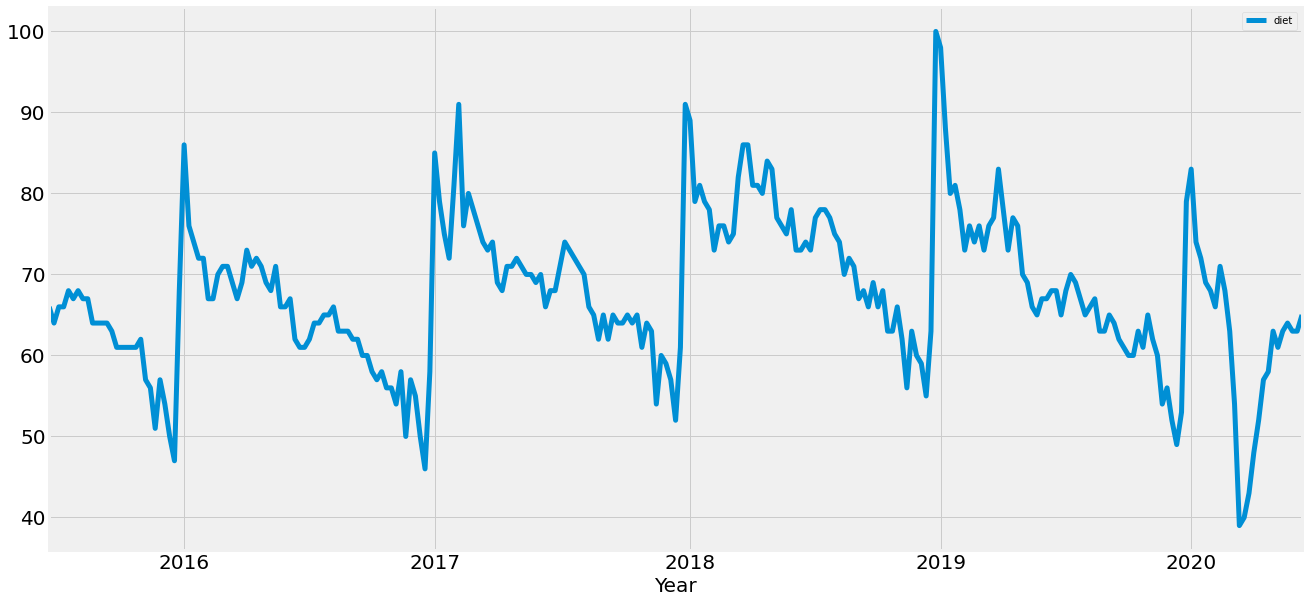

In [11]:
df.plot(figsize=(20,10), linewidth=5, fontsize=20);
plt.xlabel('Year', fontsize=20);

## Rolling Average
We will first try to plot the rolling average and check if there is any pattern

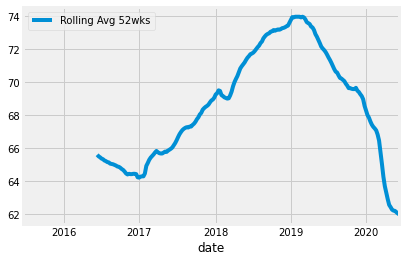

In [12]:
# .plot(figsize=(20,10), linewidth=5, fontsize=20);
#plt.xlabel('Year', fontsize=20)

# t = df.index
a = df.rolling(52).mean().plot()
# b = df.expanding().mean().plot()
# c = df.expanding().std().plot()
# plt.plot(t,a)
plt.legend(['Rolling Avg 52wks', 'Expanding Mean', 'Expand StDev'])
plt.show()

Since data is weekly basis, we will use a 52 weeks rolling average. The above graph shows the trends for keyword 'diet'. We see gradual increase from 2017 to 2019 and significant decline after 2019.

## Stationarity

### First-Order Differencing

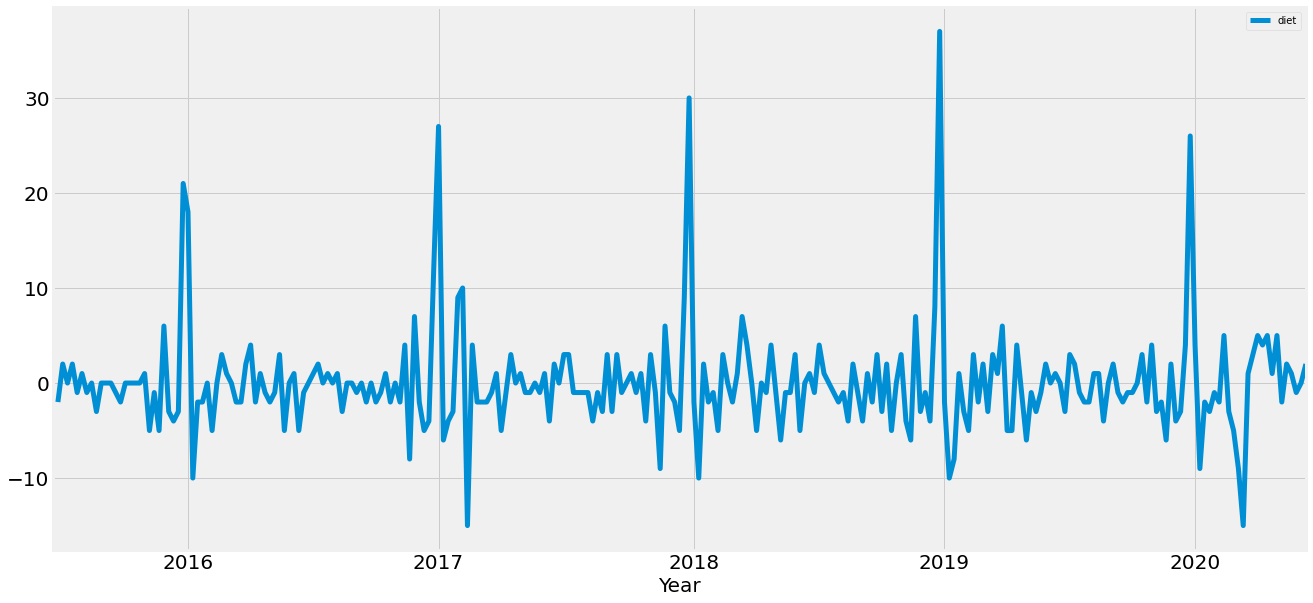

In [13]:
df.diff().plot(figsize=(20,10), linewidth=5, fontsize=20);
plt.xlabel('Year', fontsize=20);

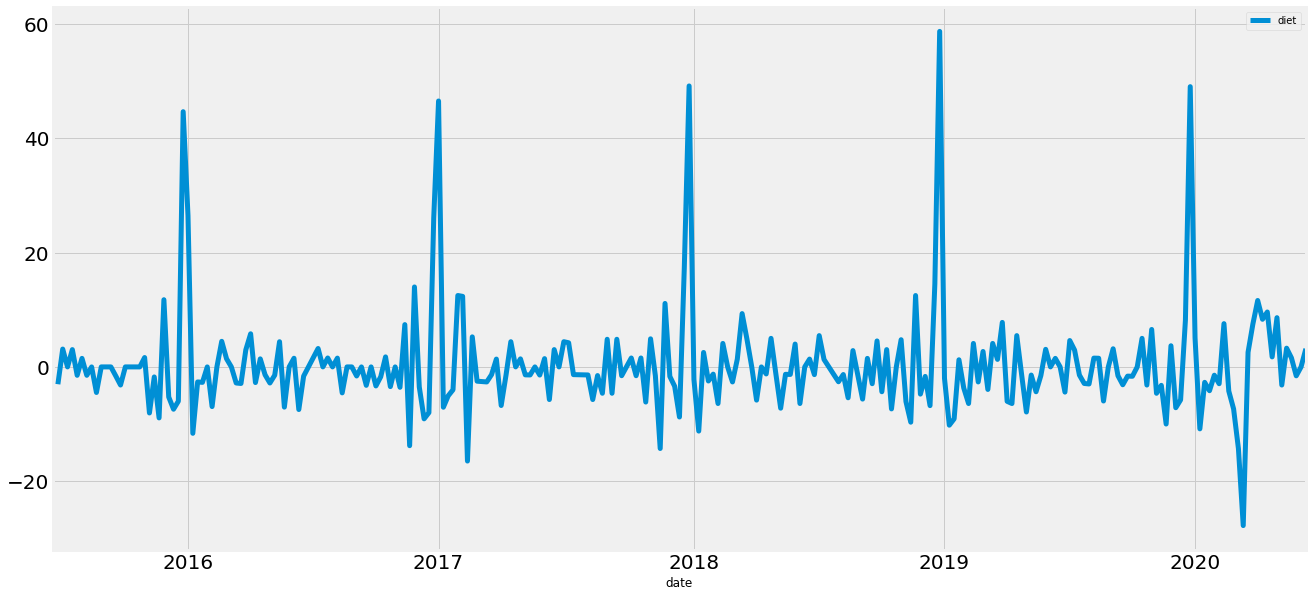

In [14]:
df.pct_change().mul(100).plot(figsize=(20,10), linewidth=5, fontsize=20);

Percentage change graph is similar to order of difference, just magnitude difference.

## Autocorrelation

### Autocorrelation (pandas plotting)

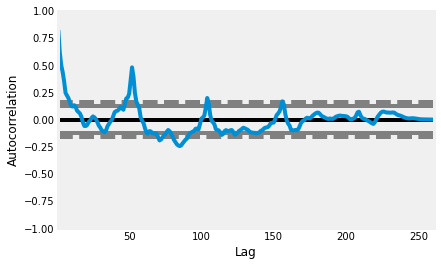

In [15]:
pd.plotting.autocorrelation_plot(df);

### Def'n: Autocorrelation and Partial Autocorrelation

** Autocorrelation **- The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.  

** Partial Autocorrelation **- The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.  

Source: [Quora](https://www.quora.com/What-is-the-difference-among-auto-correlation-partial-auto-correlation-and-inverse-auto-correlation-while-modelling-an-ARIMA-series)

### Autocorrelation (Statsmodel)

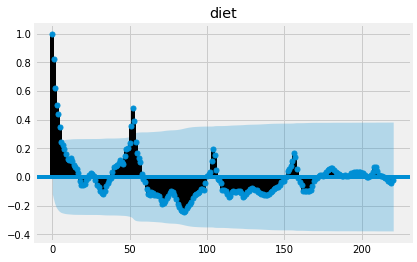

In [16]:
plot_acf(df,lags=220,title=my_keyword);

### Partial Autocorrelation (Statsmodel)

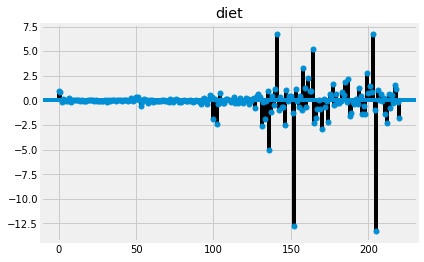

In [17]:
plot_pacf(df,lags=220,title=my_keyword);

For keyword 'diet', We see there is autocorrelation in every 52 (weeks)

## Time Series Decomposition
We can visualize our time-series with a better package in statsmodels. 

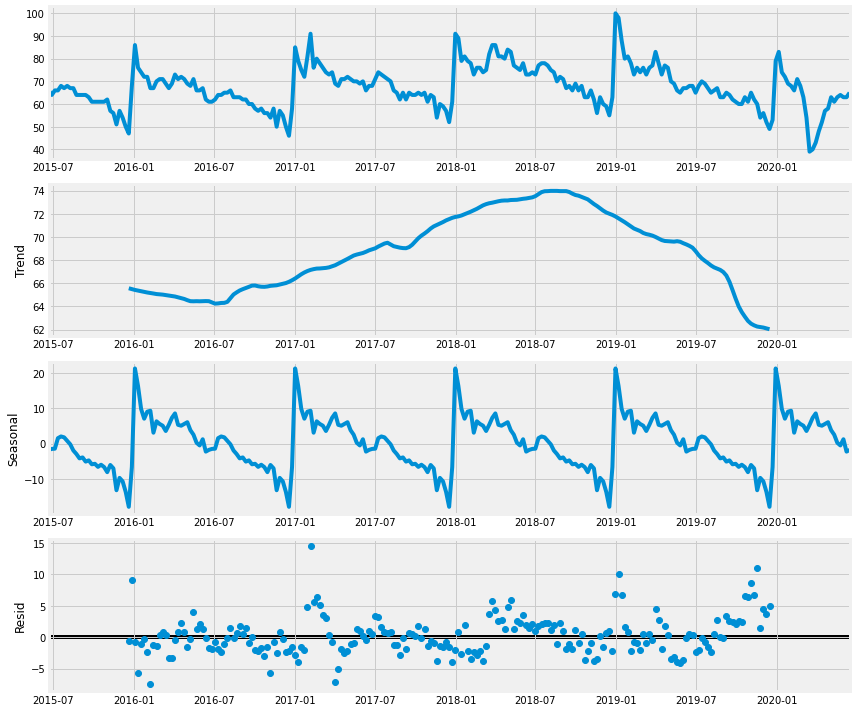

In [18]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 12, 10
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show();

### Augmented Dickey-Fuller test
An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. It is basically Dickey-Fuller test with more lagged changes on RHS.

In [19]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(df)
print("p-value of keyword: '{}' = {}".format(my_keyword,float(adf[1])))

p-value of keyword: 'diet' = 0.0017639904547957206


# Time Series Forecasting with Seasonal ARIMA
We will try and find the optimal SARIMA parameters

## Model Fitting

### How to Configure SARIMA
Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

#### Trend Elements
There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.

#### Seasonal Elements
There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period.

In [20]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 0, 0, 52)


We will try to use a 'grid search' to find an optimal set fo parameters that yield the best performance for ARIMA(p,d,q)

In [21]:
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(df,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

will try this ARIMA(1, 1, 1)x(1, 1, 0, 52)12 - AIC:8.0


In [22]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4441      0.860     -0.517      0.605      -2.129       1.241
ma.L1          0.3720      0.888      0.419      0.675      -1.369       2.113
ar.S.L52      -0.3788      0.069     -5.516      0.000      -0.513      -0.244
sigma2        15.9014      1.278     12.439      0.000      13.396      18.407


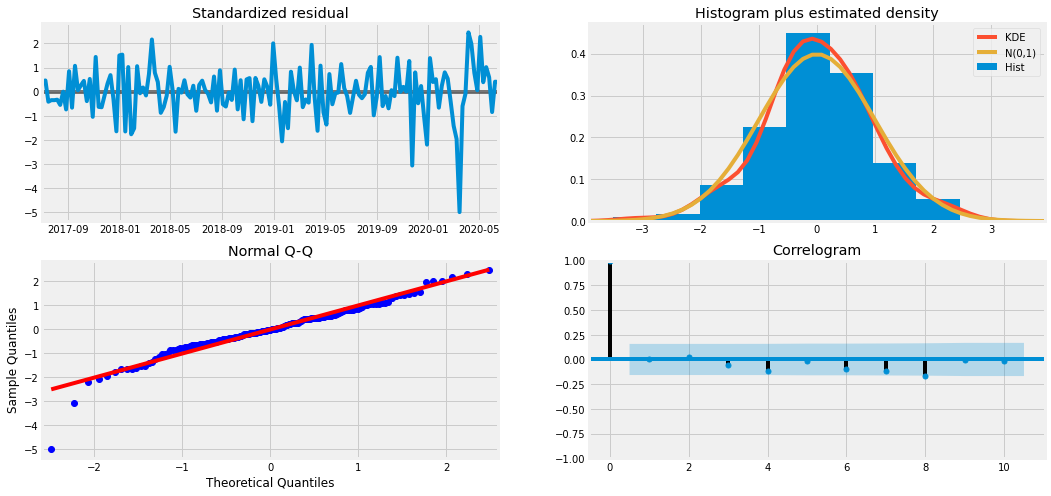

In [23]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## SARIMA Prediction

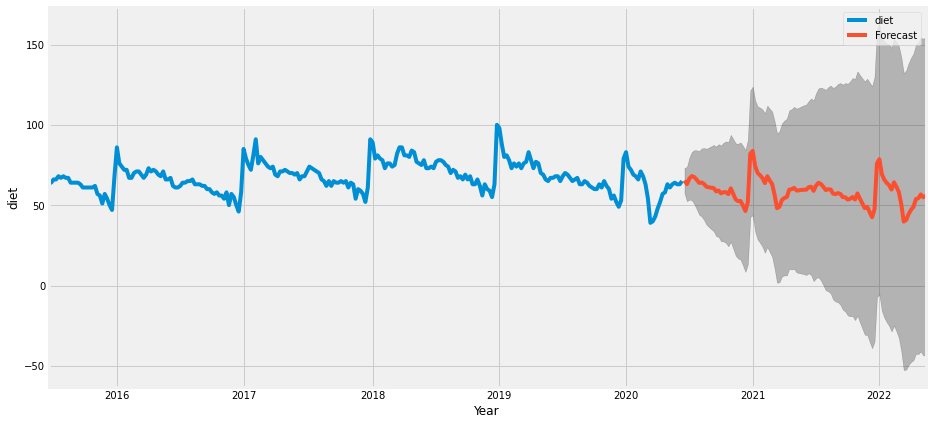

In [24]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel(my_keyword)
plt.legend()
plt.show()

## ARIMA Prediction (Machine Learning Mastery)

We will try to model this again with ARIMA (that is without seasonal parameters)

[Reference](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

In [25]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(df, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
print(residuals.describe())

ARIMA Model Results                              
Dep. Variable:                 D.diet   No. Observations:                  260
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -800.783
Method:                       css-mle   S.D. of innovations              5.263
Date:                Thu, 18 Jun 2020   AIC                           1615.567
Time:                        16:43:02   BIC                           1640.492
Sample:                    06-28-2015   HQIC                          1625.587
                         - 06-14-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0056      0.258     -0.022      0.983      -0.512       0.501
ar.L1.D.diet     0.0825      0.062      1.331      0.183      -0.039       0.204
ar.L2.D.diet    -0.2446      0.062     -3.945      0.000      -0.366     

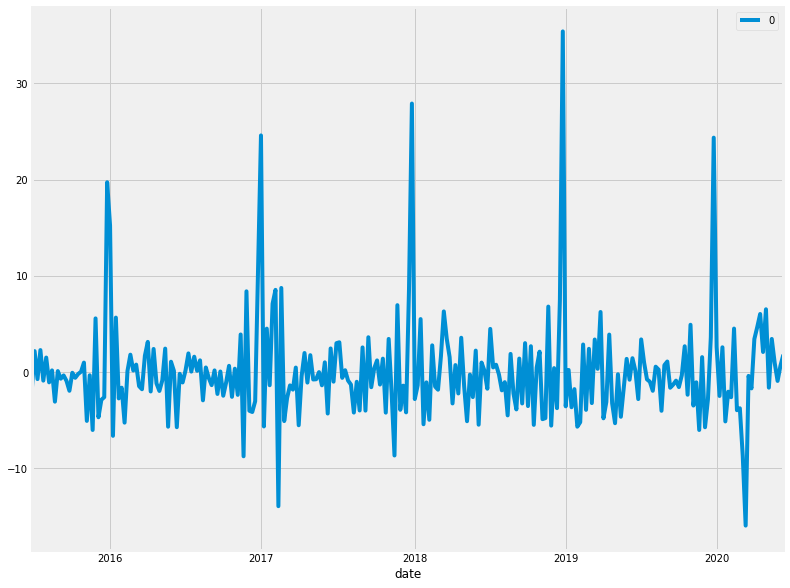

In [26]:
residuals.plot();
#plt.show()

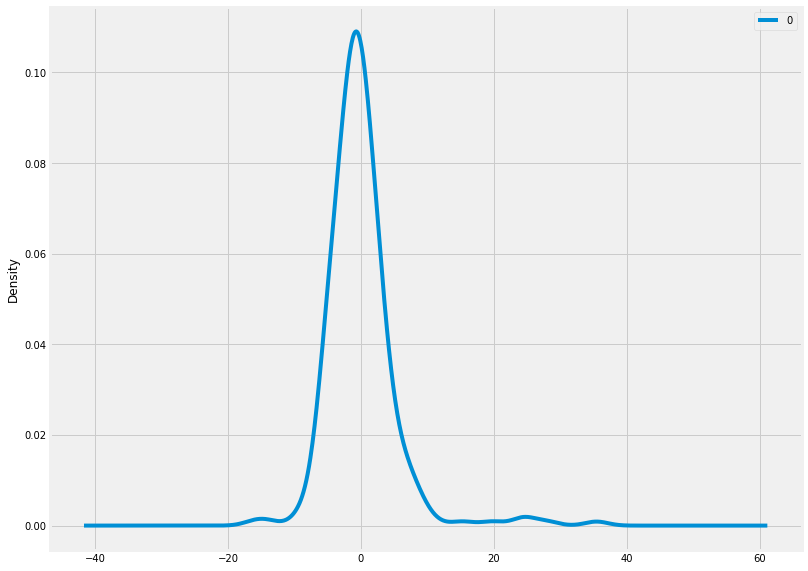

In [27]:
residuals.plot(kind='kde');
#plt.show()

We will try to do a grid search on ARIMA model

[Reference](https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/)

In [28]:
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset

series = df
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
# evaluate_models(series.values, p_values, d_values, q_values)

In [29]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
#my_order = (5, 1, 0)
my_order = (1, 0, 1)
for t in range(len(test)):
	model = ARIMA(history, order=my_order)
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


predicted=69.488767, expected=66.000000
predicted=65.740013, expected=68.000000
predicted=68.536309, expected=63.000000
predicted=63.052919, expected=63.000000
predicted=64.226720, expected=66.000000
predicted=66.892719, expected=62.000000
predicted=62.420684, expected=56.000000
predicted=57.481420, expected=63.000000
predicted=65.420896, expected=60.000000
predicted=60.825507, expected=59.000000
predicted=60.746368, expected=55.000000
predicted=56.839263, expected=63.000000
predicted=65.318053, expected=100.000000
predicted=101.091225, expected=98.000000
predicted=88.501234, expected=88.000000
predicted=82.023912, expected=80.000000
predicted=75.901573, expected=81.000000
predicted=78.751394, expected=78.000000
predicted=74.975813, expected=73.000000
predicted=71.078142, expected=76.000000
predicted=75.204895, expected=74.000000
predicted=72.040372, expected=76.000000
predicted=74.943088, expected=73.000000
predicted=71.162915, expected=76.000000
predicted=75.193781, expected=77.00000

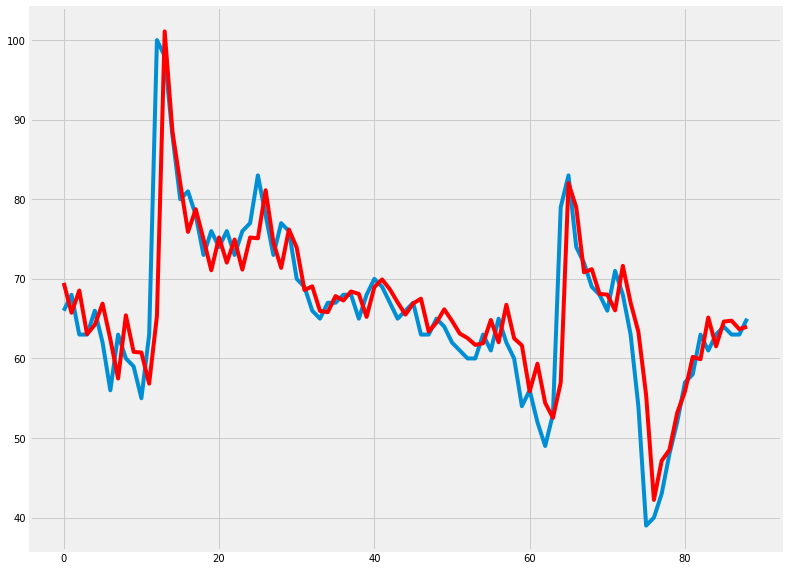

In [30]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()